In [1]:
# include controllers to the path
import sys, os
sys.path.append(os.getcwd())
sys.path.append(os.path.join(os.getcwd(), 'controllers'))

# include pipeline repo to compute performance
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', 'pipeline'))
sys.path.append(os.path.join(os.getcwd(), '..', 'pipeline', 'postprocessing'))

import cv2
import threading
import math
import time
import random
import json
import datetime
import os, shutil
import numpy as np
import multiprocess as mp

# controllers
import nbimporter
from controllers.situtils import FPSTimes
from controllers.camera import WebcamStream
from controllers.video import VideoWriter
from controllers.microphones import MicrophoneController
from controllers.position import PositionTrackerSingle, PositionTrackerDouble
from controllers.sound import SoundController, ContinuousSoundStream
from controllers.serial import MCSArduino, FakeArduino, SpeakerMotor, CableMotor
from controllers.display import SITDisplay
from controllers.island import IslandFactory

from pipeline.postprocessing.pack import pack
from pipeline.postprocessing.performance import calculate_performance, dump_performance_to_H5

## Load experiment settings

For every experimental cofiguration you can copy the original 'settings.json' file, build your own specific experimental preset, save it in this folder as e.g. 'settings_elena.json' and load it here instead of 'settings.json'.

In [2]:
cfg_filename = os.path.join('profiles', 'passive_FDA.json')

In [3]:
with open(os.path.join('profiles', 'default.json')) as json_file:
    cfg = json.load(json_file)
with open(cfg_filename) as json_file:
    cfg_local = json.load(json_file)

for key in cfg.keys():
    if key in cfg_local: # only update if the key exists in the local config, otherwise keep default (important for backward compatibility with cfg files before microphones)
        cfg[key].update(cfg_local[key])
cfg['experiment']['experiment_date'] = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# print loaded settings
#print(json.dumps(cfg, indent=4))

## Initialize session folder

Run the upcoming cell, to create a session folder and to save the chosen experimetal parameters to a JSON-file ("experiment_id_parameters.json"). The session folder will be created here where this notebook is located.

In [4]:
# This session's protocols will be saved to this folder
cfg_exp = cfg['experiment']
experiment_id = "%s_%s_%s" % (cfg_exp['subject'], cfg_exp['experiment_type'], cfg_exp['experiment_date'])
save_to = os.path.join('sessions', experiment_id)
             
if not os.path.exists(save_to):
    os.makedirs(save_to)

# update paths (assuming this paths are relative to this notebook)
cfg['video']['file_path'] = os.path.join(save_to, cfg['video']['file_path'])
cfg['video']['csv_path'] = os.path.join(save_to, cfg['video']['csv_path'])
cfg['microphones']['file_path'] = os.path.join(save_to, cfg['microphones']['file_path'])
cfg['microphones']['csv_path'] = os.path.join(save_to, cfg['microphones']['csv_path'])
cfg['position']['file_path'] = os.path.join(save_to, cfg['position']['file_path'])
cfg['position']['contour_path'] = os.path.join(save_to, cfg['position']['contour_path'])
cfg['experiment']['file_path'] = os.path.join(save_to, cfg['experiment']['file_path'])
cfg['experiment']['islands_path'] = os.path.join(save_to, 'islands.csv')
cfg['sound']['file_path'] = os.path.join(save_to, cfg['sound']['file_path'])
cfg['position']['background_light'] = os.path.join('assets', cfg['position']['background_light'])
cfg['position']['background_dark'] = os.path.join('assets', cfg['position']['background_dark'])
if 'wav_file' in cfg['sound']:
    cfg['sound']['wav_file'] = os.path.join('assets', cfg['sound']['wav_file'])
if 'continuous' in cfg['sound']:
    cfg['sound']['continuous']['wav_file'] = os.path.join('assets', cfg['sound']['continuous']['wav_file'])
    
# Saves all parameters to a JSON file with the user-defined "Experiment ID" as filename
with open(os.path.join(save_to, experiment_id + '.json'), 'w') as f:
    json.dump(cfg, f, indent=4)
    
with open(cfg['experiment']['file_path'], 'w') as f:
    # state: 0 - trial start, 1 - trial success, 2 - trial fail
    f.write('time, target_x, target_y, target_r, trial, state\n')

with open(cfg['experiment']['islands_path'], 'w') as f:
    f.write('tgt_x, tgt_y, tgt_r, d1_x, d1_y, d1_r, d2_x, d2_y, d2_r, d3_x, d3_y, d3_r\n')

In [5]:
def timeout(t_start):
    return time.time() - t_start > cfg_exp['session_duration'] if t_start is not None else False

In [6]:
def log_event(*args):  # log start / end of a trial
    with open(cfg_exp['file_path'], 'a') as f:
        f.write(",".join([str(x) for x in args]) + "\n")

In [7]:
def log_islands(islands):  # log position of the islands
    sorted_islands = sorted(islands, key=lambda x: x.sound_id, reverse=False)
    args = [(i.x, i.y, i.r) for i in sorted_islands]
    to_dump = [x for xs in args for x in xs]
        
    with open(cfg_exp['islands_path'], 'a') as f:    
        f.write(",".join([str(round(x, 4)) for x in to_dump]) + "\n")

In [8]:
def switch_light(pt, board):
    pt.switch_background()
    board.switch_light()

## Start the experiment

This cell contains code for animal tracking. We hope that the comments provided in the code suffice to understand the individual steps and to adjust them to your own setup and needs, if necessary.

- press 's' to start recording
- press 's' again to stop recording
- press 'q' to quit

The experiment will stop automatically if the pre-defined session duration is reached.

In [9]:
# actual sound selector: -1 - noise, 0 - silence, 1 - foraging, 2 - target, 3 - distractor
sound = mp.Value('i', 1)
if 'noise_when_idle' in cfg_exp and cfg_exp['noise_when_idle']:
    sound.value = -1

# experiment status: 1 - idle, 2 - running (recording, logging), 0 - stopped
status = mp.Value('i', 1)

# init the sync with the acquisition system and feeder via Arduino
if cfg['experiment']['MCSArduinoPort'] == 'fake':
    board = FakeArduino()
else:
    board = MCSArduino(cfg['experiment']['MCSArduinoPort'])

# init speaker motor control
if 'motors_port' in cfg['experiment'] and cfg['experiment']['enable_motors']:
    motor_board = SpeakerMotor(cfg['experiment']['motors_port'])
    
# init ephys cable rotation motor
if 'cable_motor_port' in cfg['experiment']:
    cable_board = CableMotor(cfg['experiment']['cable_motor_port'])

# init continuous sound, if required
if 'continuous' in cfg['sound']:
    cst = ContinuousSoundStream(cfg['sound']['continuous'])
    cst.start()
    
# start the camera stream
vs = WebcamStream(cfg['camera'])
vs.start()

# init video recorder
vw = VideoWriter(status, vs, cfg['video'])
vw.start()

# init microphone controller, if required
if cfg['microphones']['record_audio']:
    mc = mp.Process(target=MicrophoneController.run, args=(status,cfg["microphones"]))
    mc.start()

# start position tracking
pt = PositionTrackerSingle(status, vs, cfg['position']) if cfg['position']['single_agent'] else PositionTrackerDouble(status, vs, cfg['position'])
pt.start()
# print(pt.mask.shape)
# init frame renderer
dc = SITDisplay(pt, cfg['video'])

# playing sound in a separate process for performance
sounds = cfg['sound']['sounds']
commutator = {
    -1: 'noise',
    0:  'silence'
}

# ordered sound presentations - F, D, I, L
# sound_order = 1
# for s_type in ('F', 'D', 'I', 'L'):
#     keys = sorted([key for key in sounds.keys() if key.startswith(s_type)])
#     for key in keys:
#         commutator[sound_order] = key
#         sound_order += 1

# random sound presentations
sound_keys = [key for key in sounds.keys() if not key.startswith('noise')]
comm_keys  = [i+1 for i in list(range(len(sound_keys)))]
for i in comm_keys:
    key = sound_keys.pop(random.randrange(len(sound_keys)))
    commutator[i] = key

print(commutator)

sc = mp.Process(target=SoundController.run, args=(sound, status, cfg['sound'], commutator))
sc.start()

cfg_pos = cfg['position']
isl_factory = IslandFactory(cfg_pos['floor_r_in_meters'], cfg_pos['angle_compensation'], cfg['experiment'])

timers = []
fps = FPSTimes()
names = ['camera', 'video', 'position', 'main']
distr_count = cfg['experiment']['distractor_islands']
trial = 0
rewards = 0
t_start = None
target_since = None
distractor_since = None
punishment_since = None
trial_start = time.time()
phase = 0  # 0 - idle, 1 - foraging, 2 - inter-trial interval
cfg_exp = cfg['experiment']
cfg_pos = cfg['position']
islands = []
iti_distance = 0.0
last_x, last_y = None, None
cfg_exp['trial_number'] = max([int(key) for key in commutator.keys()])  # equals number of diff sounds

try:
    while trial <= cfg_exp['trial_number'] and not timeout(t_start):
        
        # ---------- rendering logic -----------
        frame = vs.read()
        if frame is None:
            time.sleep(0.1)
            continue # wait for the stream
            
        c_time = time.time()
        fps.count()
        angles, text_infos = [], []
        
        if not cfg_exp['target_angle'] == 'random':
            phi = isl_factory.phi_initial
            angles = [pt.correct_angle(phi), pt.correct_angle(phi) + np.deg2rad(cfg_exp['phi_max'])]
        
        for i, ctrl in enumerate([vs, vw, pt, fps]):  # FPS indicators
            text_infos.append('%s: %.2f FPS' % (names[i], ctrl.get_avg_fps()))
        
        if len(islands) > 0:  # target island X, Y
            target = [i for i in islands if not i.is_distractor][0]
            text_infos.append('Target: %.3f %.3f' % (target.x, target.y))

        text_infos.append('Time: %.2f' % float(c_time - t_start) if t_start is not None else 'Time: Idle')  # stopwatch
        text_infos.append('Trial: %.2f' % float(cfg_exp['trial_duration'] - (c_time - trial_start)) if phase == 1 else 'Trial: not started')
        text_infos.append('Trial: %s' % trial)
        text_infos.append('Rewards: %s' % rewards)  # rewards
        text_infos.append('In target: %.2f' % float(c_time - target_since) if target_since is not None else 'In target: --')
        text_infos.append('ITI distance: %.2f' % iti_distance if iti_distance > 0 else 'ITI distance: --')

        frame, frame_to_save = dc.render(frame, status, islands=islands, angles=angles, text_infos=text_infos)
            
        # assign the frame back to the video stream for other controllers
        vs.frame_with_infos = frame_to_save
        
        cv2.imshow('Press (s)-to start/stop, (q)-to end', frame)

        # -------- experiment logic ---------------
        
        if status.value == 2 and c_time - trial_start > cfg_exp['trial_duration']:
            log_event(c_time, 0, 0, 0, trial, 1) # log trial end
            trial += 1
            if int(sound.value) < cfg_exp['trial_number']:
                sound.value += 1
            trial_start = c_time
            log_event(c_time, 0, 0, 0, trial, 0) # log trial start
        
        # -------- key press events ---------------
        
        k = cv2.waitKey(33)
        
        # light on/off
        if k == ord('l'):
            switch_light(pt, board)
        
        # motors
        if k == ord('d'):
            if cfg['experiment']['enable_motors']:
                motor_board.switch_diodes()
         
        # ephys cable on top
        if k == ord('i') and 'cable_motor_port' in cfg['experiment']:
            tf = threading.Timer(0, cable_board.turn_CCW, args=[])
            tf.start()
        if k == ord('o') and 'cable_motor_port' in cfg['experiment']:
            tf = threading.Timer(0, cable_board.turn_CW, args=[])
            tf.start()
            
        # feeding
        if k == ord('f'):
            tf = threading.Timer(0, board.feed, args=[])
            tf.start()

        if k == ord('c'):
            f_name = cfg_pos['background_light'] if pt.is_light else cfg_pos['background_dark']
            cv2.imwrite(f_name, dc.masked_frame)
            tf = threading.Timer(0.2, pt.reload_background, args=[])
            tf.start()            

        # quit the session
        if k == ord('q'):
            break

        # start the experiment
        if k == ord('s'):
            board.start_or_stop()  # start/stop data acquisition
            c_time = time.time()   # more accurate time
            
            if cfg['experiment']['enable_motors']:
                if not motor_board.diodes_on:
                    motor_board.switch_diodes()

            if status.value == 1: # start the session
                if t_start is None:
                    t_start = c_time
                trial_start = c_time
                status.value = 2
                
                # init_new_trial
                sound.value = 1
                phase = 1
                trial += 1

                # log trial start
                log_event(c_time, 0, 0, 0, trial, 0) # log trial start
                
            elif status.value == 2:  # pause the session
                if len(islands) > 0:
                    tgt = [i for i in islands if not i.is_distractor][0]
                    x, y, r = round(tgt.x, 4), round(tgt.y, 4), round(tgt.r, 4)
                else:
                    x, y, r = 0, 0, 0
                log_event(c_time, x, y, r, trial, -1)  # log experiment break
                
                if 'noise_when_idle' in cfg_exp and cfg_exp['noise_when_idle']:
                    sound.value = -1
                status.value = 1
                phase = 0
                islands = []
                for t in timers:
                    t.cancel()
                    
        if k == ord('a'):
            sound.value = -1 if sound.value >= 0 else 0
            switch_light(pt, board)  # turn lights off 

finally:
    if status.value == 2:  # stop data acquisition, in case exited via timeout
        board.start_or_stop()
        if len(islands) > 0:
            tgt = [i for i in islands if not i.is_distractor][0]
            x, y, r = round(tgt.x, 4), round(tgt.y, 4), round(tgt.r, 4)
        else:  
            x, y, r = 0, 0, 0
        log_event(c_time, x, y, r, trial, -1)  # log experiment end
        
    status.value = 0
    time.sleep(0.01)
    for t in timers:
        t.cancel()
    
    #if board.is_light_off:
    #    board.switch_light()  # turn light back on
    #    time.sleep(0.1)
    board.exit()
    
    if cfg['experiment']['enable_motors']:
        if motor_board.diodes_on:
            motor_board.switch_diodes()
        motor_board.exit()
    if 'cable_motor_port' in cfg['experiment']:
        cable_board.exit()
    
    cv2.destroyAllWindows()
    sc.join()
    for ctrl in [pt, vw, vs]:
        ctrl.stop()

    # stop microphones recording process
    if cfg['microphones']['record_audio']:
        mc.join()

    if 'continuous' in cfg['sound']:
        time.sleep(cfg['sound']['continuous']['end_sleep'])
        cst.stop()

Webcam stream 1024.0:768.0 at 30.00 FPS started
{-1: 'noise', 0: 'silence', 1: 'D6', 2: 'F5', 3: 'I3', 4: 'F4', 5: 'D1', 6: 'F3', 7: 'F1', 8: 'D5', 9: 'I1', 10: 'F2', 11: 'D2', 12: 'D3', 13: 'I4', 14: 'I2', 15: 'D4'}
Position tracker stopped
Video writer stopped
Camera released


### Merge data in HDF5 file

In [10]:
session_path = save_to
#trial = 5
#session_path = os.path.join('sessions', '2021-07-30_09-24-14')  # some particular session
#session_path = 'Y:\\Michael\\FreeBehaving\\SIT_sessions\\51_aSIT_2021-12-03_13-31-51'

In [11]:
if not trial > 0:
    raise SystemExit('Nothing recorded. No sense to continue.')

# do pack data to HDF5
h5name = pack(session_path)
trial = 0

D:\runSIT\..\pipeline\postprocessing\pack.py:59: UserWarning: loadtxt: Empty input file: "sessions\57_SIT_passive_2024-02-01_16-22-22\islands.csv"
  data = np.loadtxt(filename, delimiter=',', skiprows=1)


### Plot sessions stats

In [12]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
from scipy import signal

In [13]:
arena_r = 0.4  # in meters

with h5py.File(h5name, 'r') as f:
    tl = np.array(f['processed']['timeline'])
    trial_idxs = np.array(f['processed']['trial_idxs'])

Text(0.5, 1.0, 'Speed')

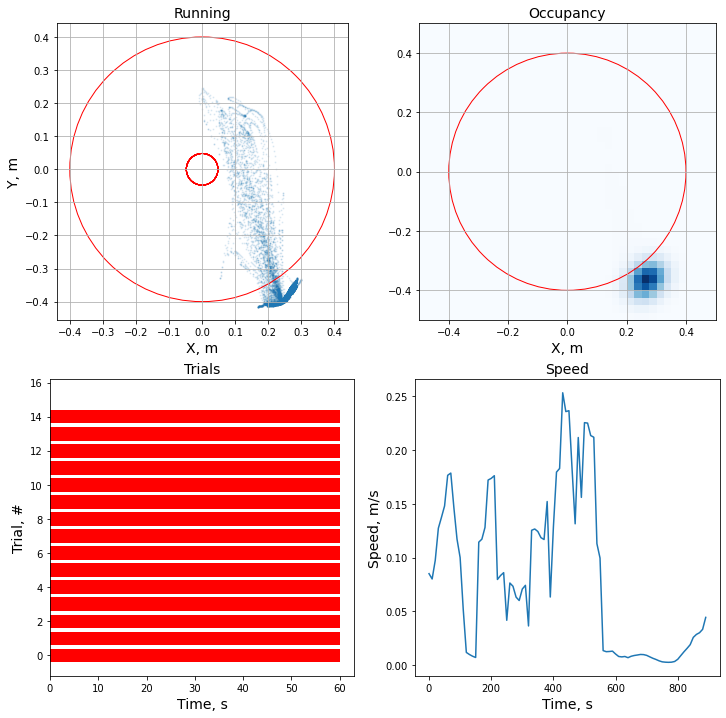

In [14]:
fig = plt.figure(figsize=(12, 12))

# trajectory and islands
ax = fig.add_subplot(221)
ax.scatter(tl[:, 1], tl[:, 2], s=1, alpha=0.1)  # positions
scat = ax.scatter(trial_idxs[:, 2], trial_idxs[:, 3], s=1000, facecolors='none', edgecolors='r')  # islands, radius approx.
ax.add_patch(plt.Circle((0, 0), arena_r, color='r', fill=False))
ax.set_aspect('equal')
ax.set_xlabel('X, m', fontsize=14)
ax.set_ylabel('Y, m', fontsize=14)
ax.set_title('Running', fontsize=14)
ax.grid()

# occupancy
sigma = 0.1
lin_profile = np.linspace(-15, 15, 20)
bump = np.exp(-sigma * lin_profile**2)
bump /= np.trapz(bump)  # normalize to 1
kernel = bump[:, np.newaxis] * bump[np.newaxis, :]
occupancy_map, _, _ = np.histogram2d(tl[:, 1], tl[:, 2], bins=[40, 40], range=np.array([[-0.5, 0.5], [-0.5, 0.5]]))
occupancy_map = signal.convolve2d(occupancy_map, kernel, mode='same')

ax = fig.add_subplot(222)
ax.imshow(occupancy_map.T, origin='lower', extent=(-0.5, 0.5, -0.5, 0.5), cmap='Blues')
ax.add_patch(plt.Circle((0, 0), arena_r, color='r', fill=False))
ax.set_xlabel('X, m', fontsize=14)
ax.set_title('Occupancy', fontsize=14)
ax.grid()

# trials
durations = tl[trial_idxs[:, 1].astype(int)][:, 0] - tl[trial_idxs[:, 0].astype(int)][:, 0]
colors = ['red' if x == 1 else 'grey' for x in trial_idxs[:, 5]]

ax = fig.add_subplot(223)
ax.barh(np.arange(len(trial_idxs)), durations, color=colors, align='center')
ax.set_xlabel('Time, s', fontsize=14)
ax.set_ylabel('Trial, #', fontsize=14)
ax.set_title('Trials', fontsize=14)

# speed
ax = fig.add_subplot(224)

s_rate = 100  # Hz
window = 60   # secs
step = 10     # secs
duration = tl[-1][0]
x_vals = np.arange(int(duration/step))

inst_speed = [tl[x*step*s_rate:(x*step + window)*s_rate][:, 3].mean() for x in x_vals]
ax.plot(x_vals*step, inst_speed)
ax.set_ylabel('Speed, m/s', fontsize=14)
ax.set_xlabel('Time, s', fontsize=14)
ax.set_title('Speed', fontsize=14)

## Performance

In [15]:
h5name = os.path.join(session_path, experiment_id + '.h5')
jsname = os.path.join(session_path, experiment_id + '.json')

# loading position and trial data
with h5py.File(h5name, 'r') as f:
    tl = np.array(f['processed']['timeline'])  # time, X, Y, speed
    trial_idxs = np.array(f['processed']['trial_idxs'])  # idx start, idx end, X, Y, R, trial result (idx to tl)

# loading session configuration
with open(jsname, 'r') as f:
    cfg = json.load(f)

timepoints = cfg['experiment']['timepoints']
s_duration = cfg['experiment']['session_duration']
if len(timepoints) > 0:
    periods = [[0, s_duration], [0, timepoints[0]], [timepoints[1], timepoints[2]], [timepoints[3], s_duration]]
else:
    periods = [[0, s_duration]]

# separate ALL, L, D, L'
ds_names = ['performance_ALL', 'performance_L', 'performance_D', 'performance_Lp']
ds_names = ['performance_ALL']  # only light

for i, ds_name in enumerate(ds_names):
    t_start, t_end = periods[i]
    trial_starts = tl[trial_idxs[:, 0].astype(np.int32)][:, 0]
    trial_ends   = tl[trial_idxs[:, 1].astype(np.int32)][:, 0]
    tr_idxs = trial_idxs[(trial_starts >= t_start) & (trial_ends <= t_end)]

    dataset = calculate_performance(tl, tr_idxs, cfg)
    dump_performance_to_H5(h5name, ds_name, dataset)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
fig = plt.figure(figsize=(4, 4))

with h5py.File(h5name, 'r') as f:
    perf = np.array(f['analysis']['performance_ALL'])
    x = perf[:, 6]

ax = fig.add_subplot(111)

ax.plot(x, perf[:, 0])  # performance
ax.plot(x, perf[:, 3])  # chance
ax.fill_between(x, perf[:, 0] + perf[:, 1], perf[:, 0] + perf[:, 2], alpha=0.4)
ax.fill_between(x, perf[:, 3] + perf[:, 4], perf[:, 3] + perf[:, 5], alpha=0.4)
ax.set_ylim(0, 110)
ax.set_xlim(0, 65)
ax.grid()
ax.set_title(experiment_id[-19:], fontsize=14)
ax.set_xlabel('Time, s', fontsize=14)

if i == 0:
    ax.set_ylabel('Successful trials, %', fontsize=14)
        
fig.tight_layout()

In [ ]:
import this
